In [67]:
from glob import glob
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from statsmodels.stats.multitest import multipletests
from goatools.test_data.genes_NCBI_9606_All import GENEID2NT
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.obo_parser import GODag
from goatools.godag_obosm import OboToGoDagSmall
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
meta = pd.read_csv('meta.csv',index_col=0)
meta.replace('Positive',1).replace('Negative',0)

,Age,SjD Diagnosis,Focus Score,SSA,SSB,ANA,RF
BRA99,48.0,1,4.0,1,1.0,1.0,0.0
BRA103,NaN,1,0.0,1,1.0,0.0,1.0
BRA12,NaN,1,4.0,1,1.0,0.0,0.0
BRA16,NaN,1,4.0,1,1.0,1.0,0.0
BRA109,40.0,1,4.0,1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
MSG_3713,47.0,0,0.0,0,NaN,0.0,0.0
MSG_3717,43.0,0,0.0,0,NaN,0.0,0.0
MSG_3719,26.0,0,0.0,0,NaN,0.0,0.0
MSG_3743,24.0,0,0.0,0,NaN,0.0,0.0


<Axes: >

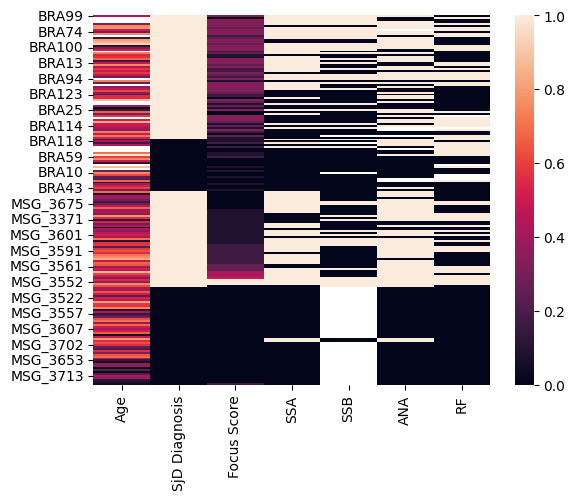

In [3]:
hm = meta.replace('Positive',1).replace('Negative',0)
hm = (hm - hm.min()) / (hm.max() - hm.min())
sns.heatmap(hm)

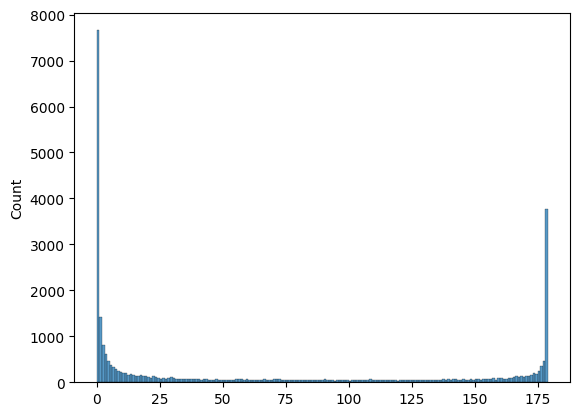

In [4]:
CPM = pd.read_csv('all_gene.csv',index_col=0)
genes = (CPM == 0).sum(axis=1)
sns.histplot(genes,binwidth=1)
plt.show()

/var/folders/5y/4ldrp3j959b0fcn9pvx95rjrqrkdq2/T/ipykernel_21281/2875556054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE['Color'][(DE['padj'] > -np.log10(0.05)) & (DE['log2FoldChange'] < -1)] = 'tab:orange'
/var/folders/5y/4ldrp3j959b0fcn9pvx95rjrqrkdq2/T/ipykernel_21281/2875556054.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE['Color'][(DE['padj'] > -np.log10(0.05)) & (DE['log2FoldChange'] > 1)] = 'tab:red'


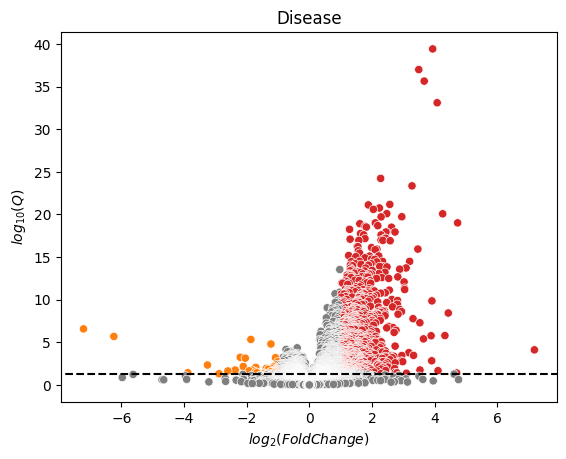

In [5]:

DE = pd.read_csv('de/gene.disease.csv',index_col=0)
DE['padj'] = -DE['padj'].apply(np.log10)
DE['Color'] = 'tab:gray'
DE['Color'][(DE['padj'] > -np.log10(0.05)) & (DE['log2FoldChange'] < -1)] = 'tab:orange'
DE['Color'][(DE['padj'] > -np.log10(0.05)) & (DE['log2FoldChange'] > 1)] = 'tab:red'
plt.plot([-50,50],[-np.log10(0.05),-np.log10(0.05)],'--',c='k')
DE = DE.dropna()
sns.scatterplot(data=DE,x='log2FoldChange',y='padj',c=DE['Color'])
plt.xlim(DE['log2FoldChange'].min()*1.1,DE['log2FoldChange'].max()*1.1)
plt.ylabel('$log_{10}(Q)$'); plt.title('Disease'); plt.xlabel('$log_2(Fold Change)$')
plt.savefig('figures/volcano_disease.pdf',format='pdf',bbox_inches='tight')

In [213]:
obodag = GODag("../go-basic.obo")
objanno = Gene2GoReader('../gene2go', taxids=[9606])
ns2assoc = objanno.get_ns2assc()
RS2NT = {GENEID2NT[nt][5]:nt for nt in GENEID2NT}; NT2RS = {nt:GENEID2NT[nt][5] for nt in GENEID2NT}

go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms
HMS:0:00:39.402103 346,071 annotations, 20,759 genes, 18,733 GOs, 1 taxids READ: ../gene2go 


In [11]:
def run_go(glist,label):
	glist = glist.map(RS2NT).dropna().astype('int')
	goeaobj = GOEnrichmentStudyNS(GENEID2NT.keys(),ns2assoc,obodag,alpha = 0.05,methods = ['fdr_bh'])
	goea_results_all = goeaobj.run_study(glist, prt=None)
	goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
	#plot_results("go.plots/"+label+".png", goea_results_sig)
	return goea_results_sig

In [237]:
DE = []; G = []
for de in glob('de/gene*'):
	label = de.split('.')[1]+'_de'
	de = pd.read_csv(de,index_col=0)
	de['Test'] = label
	DE.append(de)

DE = pd.concat(DE)
DE['Q'] = multipletests(DE['pvalue'],method='fdr_bh',alpha=0.0)[0]

#vals.append(glist)
#labels.append(label.replace('_de',''))

In [238]:
subDE = DE[DE['Q'] & (DE['Test'] == 'ana_de')].index
res = run_go(subDE,'ana_de')
obodag.draw_lineage([r.goterm for r in res],output='go.plots/ana_de.svg',gml=True,draw_children=False)


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/ana_de.gml
lineage info for terms ['GO:0002376', 'GO:0006955', 'GO:0002682', 'GO:0008150', 'GO:0050789', 'GO:0065007', 'GO:0050896', 'GO:0050794', 'GO:0002684', 'GO:0050776', 'GO:0006952', 'GO:0048583', 'GO:0009987', 'GO:0048518', 'GO:0048584', 'GO:0009607', 'GO:0043207', 'GO:0050778', 'GO:0051239', 'GO:0048522', 'GO:0007165', 'GO:0044419', 'GO:0050865', 'GO:0002694', 'GO:0009605', 'GO:0051707', 'GO:0051249', 'GO:0045321', 'GO:0007166', 'GO:0006950', 'GO:0001775', 'GO:0098542', 'GO:0046649', 'GO:1903037', 'GO:0050863', 'GO:0001817', 'GO:0032101', 'GO:0140546', 'GO:0051240', 'GO:0022407', 'GO:0048519', 'GO:0050867', 'GO:1903039', 'GO:0002696', 'GO:0022409', 'GO:0051251', 'GO:0002250', 'GO:0019222', 'GO:0031347', 'GO:0030155', 'GO:0048523', 'GO:0060255', 'GO:0001819', 'GO:0070663', 'GO:0002253', 'GO:0050670', 'GO:0002697', 'GO:0032944', 'GO:0031323', 'GO:0002683', 'GO:0002252', 'GO:0002764', 'GO:0045785', 'GO:0050870', 'GO:0032501', 'GO:0045087', 'GO:0080134

In [99]:
G = pd.read_csv('all_gene.csv',index_col=0)
G = G.divide(G.sum()) * 1000000
res = pd.read_csv('res3.csv',index_col=0)
P = []; L = []
for gene in res['Gene'].value_counts().index:
    try:
        boolset = res[res['Gene'] == gene][res.columns[res.columns.str.contains('BRA')+res.columns.str.contains('MSG')]]
        g = G[boolset.columns].loc[gene]
        p = pearsonr(g,boolset.values.reshape(-1)).pvalue
        if not np.isnan(p):
            P.append(p)
            L.append(gene)
    except:
        pass

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [136]:
Q = multipletests(P,method='fdr_bh')
Q[0]

array([ True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True, False,
        True])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'IFNG-AS1'),
  Text(1, 0, 'LINC02453'),
  Text(2, 0, 'DLEU2'),
  Text(3, 0, 'CD19'),
  Text(4, 0, 'JAML'),
  Text(5, 0, 'KDM6B'),
  Text(6, 0, 'ZNF682'),
  Text(7, 0, 'APOL1'),
  Text(8, 0, 'METTL7A'),
  Text(9, 0, 'MIGA1'),
  Text(10, 0, 'FCRL2'),
  Text(11, 0, 'FCRL1'),
  Text(12, 0, 'RBMS3'),
  Text(13, 0, 'GZMK'),
  Text(14, 0, 'HLA-DQA1'),
  Text(15, 0, 'ZFAND3'),
  Text(16, 0, 'COX7A2'),
  Text(17, 0, 'STX7'),
  Text(18, 0, 'CTSB'),
  Text(19, 0, 'LINC00861'),
  Text(20, 0, 'MS4A1')])

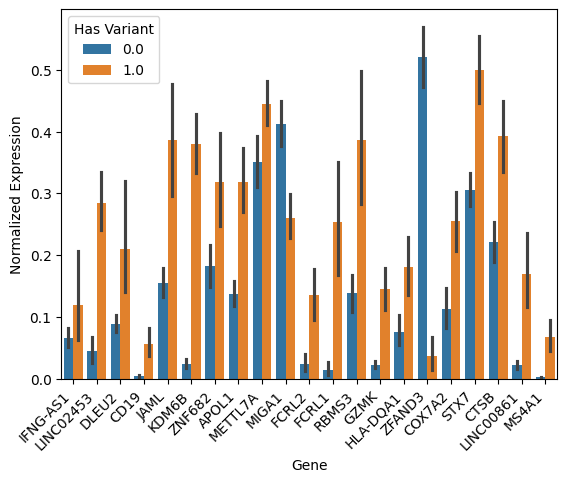

In [133]:
DF = []
for i in range(len(L)):
    if Q[0][i]:
        boolset = res[res['Gene'] == L[i]][res.columns[res.columns.str.contains('BRA')+res.columns.str.contains('MSG')]]
        g = G[boolset.columns].loc[L[i]]
        df = pd.DataFrame([g,boolset.loc[boolset.index[0]]],index = ['Expression (CPM)','Has Variant']).T
        df['Gene'] = L[i]
        df['Normalized Expression'] = df['Expression (CPM)'] / df['Expression (CPM)'].max()
        DF.append(df)

sns.barplot(data=pd.concat(DF),x='Gene',y='Normalized Expression',hue='Has Variant')
plt.xticks(ha='right',rotation=45)

In [174]:
res8 = pd.read_csv('res8.csv',index_col=0)
res8SjD = res8[res8['Test'] == 'SjD']
(res8SjD['#CHROM']+':'+res8SjD.POS.astype('str')+'-'+(res8SjD.POS+1).astype('str')).to_list()

['chr1:23709534-23709535',
 'chr1:23710061-23710062',
 'chr1:23710256-23710257',
 'chr1:52705737-52705738',
 'chr1:156815610-156815611',
 'chr1:156883059-156883060',
 'chr1:156933180-156933181',
 'chr1:158946205-158946206',
 'chr1:224977171-224977172',
 'chr1:224977181-224977182',
 'chr2:65040439-65040440',
 'chr2:88863122-88863123',
 'chr2:148509265-148509266',
 'chr2:204442750-204442751',
 'chr2:208140899-208140900',
 'chr2:208141029-208141030',
 'chr2:232197087-232197088',
 'chr3:14947081-14947082',
 'chr3:28295032-28295033',
 'chr3:28295041-28295042',
 'chr3:28295045-28295046',
 'chr3:28295047-28295048',
 'chr3:117015019-117015020',
 'chr3:117015020-117015021',
 'chr3:117015024-117015025',
 'chr3:117015026-117015027',
 'chr3:117015029-117015030',
 'chr3:153161901-153161902',
 'chr3:159315095-159315096',
 'chr3:159315160-159315161',
 'chr4:38746671-38746672',
 'chr4:115873785-115873786',
 'chr5:55861694-55861695',
 'chr5:150521125-150521126',
 'chr5:151628623-151628624',
 'chr5:1516

In [200]:
# echo '##fileformat=VCFv4.1' > res8.vcf
# sed -r 's/,("[^"]*")*/\t\1/g' res8.csv | cut -f2- >> res8.vcf
# bedtools intersect -wao -a res8.vcf -b all_ens.bed > res8.gen
res8gen = pd.read_csv('res8.gen',sep='\t',header=None)
G = []
for row in res8SjD.iterrows():
    res8gensub = res8gen[(res8gen[0] == row[1]['#CHROM']) & (res8gen[1] == row[1]['POS'])]
    res8gensub = res8gensub[res8gensub[181] == 'protein_coding']
    gene_names = res8gensub[177].value_counts().index
    gene_names = list(set([gene_name.split('-')[0] for gene_name in gene_names]))
    gene_names = [gene_name for gene_name in gene_names if 'CHM13_' not in gene_name and '.' not in gene_name]
    G += gene_names

119

In [206]:
res = run_go(pd.Index(G),'SjD_GATK8')
obodag.draw_lineage([r.goterm for r in res],output='disease_GATK8.svg',gml=True,draw_children=False)


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to disease_GATK8.gml
lineage info for terms ['GO:0008150', 'GO:0050789', 'GO:0050794', 'GO:0065007', 'GO:0009987', 'GO:0002376', 'GO:0050896', 'GO:0048518', 'GO:0006955', 'GO:0002682', 'GO:0048522', 'GO:0007165', 'GO:0002684', 'GO:0048584', 'GO:0048583', 'GO:0019222', 'GO:0009893', 'GO:0031325', 'GO:0010604', 'GO:0050776', 'GO:0042221', 'GO:0051239', 'GO:0002757', 'GO:0051716', 'GO:0007166', 'GO:0048523', 'GO:0002764', 'GO:0060255', 'GO:0002253', 'GO:0048519', 'GO:0050778', 'GO:0046649', 'GO:0031323', 'GO:0030595', 'GO:0070887', 'GO:0010033', 'GO:0006950', 'GO:0045321', 'GO:0002237', 'GO:0030155', 'GO:0002694', 'GO:0071704', 'GO:0060326', 'GO:0001775', 'GO:0050865', 'GO:0043170', 'GO:0050900', 'GO:0023051', 'GO:0032502', 'GO:0010646', 'GO:0006807', 'GO:0043207', 'GO:0051173', 'GO:0009966', 'GO:0009607', 'GO:0080134', 'GO:0010468', 'GO:0008152', 'GO:0051234', 'GO:0022407', 'GO:0006954', 'GO:0010556', 'GO:0051249', 'GO:0051171', 'GO:0031347', 'GO:0031326', 'GO:0009889',